In [40]:
import numpy as np
import glob, os
from keras import layers as ly
from keras.models import Sequential, load_model, Model
from keras.layers import Input, Lambda, LSTM, Dense, RepeatVector, TimeDistributed
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
import copy
from scipy.spatial.distance import cosine as cosine_distance
from keras.models import model_from_json
from collections import Counter
import import_ipynb
import drawingGraph as G
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [41]:
def getIndexFromGraph(filename):
    index = int(filename.split('-')[0].replace('graph', ''))
    return index

In [42]:
def calculateGraphGroup(num_dict):
    for index, data in enumerate(all_data):
        loc = getIndexFromGraph(graph_group[index])
        num_dict[loc] += 1
    return num_dict

In [43]:
def getEmbeddingSum():
    sum_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index, data in enumerate(all_data):
        data = data.reshape(1, data.shape[0], data.shape[1])
        embedded = encoder.predict(data)
        loc = getIndexFromGraph(graph_group[index])
        sum_embedding[loc] += embedded.reshape(embedded.shape[1])
    return sum_embedding

In [44]:
def getEmbeddingAvg():
    avg_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    sum_embedding = getEmbeddingSum()
    for index in range(graph_length):
        avg_embedding[index] = sum_embedding[index] / num_dict[index]
    return avg_embedding

In [45]:
def getEmbeddingVector(index):
    data_index = []
    data = []
    counts = num_dict[index]
    for num, i in enumerate(graph_group):
        if index == getIndexFromGraph(i):
            data_index.append(num)
        if len(data_index) == counts:
            break
    for i in data_index:
        dt = all_data[i].reshape(1, all_data[i].shape[0], all_data[i].shape[1])
        dt = encoder.predict(dt)
        dt = dt.reshape(dt.shape[1])
        data.append(dt)
    return data

In [46]:
def getMode(values):
    values.sort()
    mode = Counter(values).most_common()
    maximum = mode[0][1]
    if maximum == 1:
        return values.mean()
    else:
        dt = []
        for m in mode:
            if maximum == m[1]:
                dt.append(m[0])
            else:
                break
        return np.array(dt).mean()

In [47]:
def getEmbeddingMode(): # 최빈값
    mode_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            mode_embedding[index][count] = getMode(values)
        mode_embedding[index] = np.array(mode_embedding[index])
    return mode_embedding

In [48]:
def getEmbeddingExceptMinMax():
    except_embedding = [[0 for i in range(embedded_length)] for i in range(graph_length)]
    for index in range(graph_length):
        vectors = np.array(getEmbeddingVector(index))
        for count in range(embedded_length):
            values = vectors[:, count:count+1].reshape(num_dict[index])
            values.sort()
            except_embedding[index][count] =  values[1:-1].mean()
        except_embedding[index] = np.array(except_embedding[index])
    return except_embedding

In [49]:
def euclidean_distance(a, b):
    a = np.array(a)
    b = np.array(b)
    return np.sqrt(np.sum(a-b) ** 2)

In [50]:
def getGraphOrder(dist):
    ordered = copy.deepcopy(dist)
    ordered.sort()
    
    names = []
    
    for item in ordered:
        for index, d in enumerate(dist):
            if item == d:
                names.append(index)#+1)
                break
    return names, ordered

In [51]:
def getDistFromEmbedding(distance_measure, embedding, obj):
    if embedding  == 'sum':
        embeddings = sum_embedding
    elif embedding == 'avg':
        embeddings = avg_embedding
    elif embedding == 'mode':
        embeddings = mode_embedding
    elif embedding =='except':
        embeddings = except_embedding
    
    dist = []
    for embed in embeddings:
        if distance_measure == 'euc':
            dist.append(euclidean_distance(obj, embed))
        else:
            dist.append(cosine_distance(obj, embed))
    return dist

In [52]:
def getTopData(n, datasets, names):
    data = []
    for n in names[:n+1]:
        data.append(datasets[n])
    return data

In [53]:
def draw(drawobj, drawobj_name, dir_name, save):
    for index, obj in enumerate(drawobj):
        G.drawGraph(dir_name, 'graph' + str(drawobj_name[index]), index, obj, save)

In [193]:
filename = input('filename: ')
json_file = open("model/lstm_autoencoder.json", "r") #"+filename+"
loaded_model_json = json_file.read() 
loaded_model = model_from_json(loaded_model_json)
loaded_model.load_weights('mse_weights/'+ filename + '.h5')

filename: weights317-0.0624


In [194]:
sequence_type = input('type(bfs? dfs?): ')
if sequence_type == 'dfs':
    dir = './latest_sequence/dfs/*'
else:
    dir = './latest_sequence/bfs/*'

# file read
all_data = []
sequence_length = []
graph_group = []
for file in sorted(glob.glob(dir)):
    graph_group.append(file.split('/')[-1].replace('.txt', ''))
    datasets = []
    for f in open(file, 'r'):
        (u, v, w) = f[1:-2].split(',')
        datasets.append([int(u), int(v), float(w)])
    sequence_length.append(len(datasets))
    all_data.append(datasets)
all_data = np.array([np.array(arr) for arr in all_data])

type(bfs? dfs?): 


In [195]:
graph_length = len(glob.glob('./latest_graph_data/*'))
embedded_length = 64

In [196]:
lstm_autoencoder = loaded_model

In [197]:
encoder = Model(lstm_autoencoder.input, lstm_autoencoder.layers[2].output)

In [198]:
num_dict = { i:0 for i in range(graph_length)}
num_dict = calculateGraphGroup(num_dict)

In [199]:
sum_embedding = getEmbeddingSum()
avg_embedding = getEmbeddingAvg()
mode_embedding = getEmbeddingMode()
except_embedding = getEmbeddingExceptMinMax()

In [200]:
#그래프 그리기 위해 각 그래프 그룹 가운데 하나씩 가져옴. (모든 노드에 대한 sequence 에서 하나의 노드 시퀀스만 가져오기) 
datasets = [[] for i in range(graph_length)]
for n, data in zip(graph_group, all_data):
    index = int(n.split('-')[0].replace('graph', ''))
    if len(datasets[index]) == 0:
        d = []
        for row in data:
            u, v, w = row
            d.append([int(u), int(v), float(w)])
        datasets[index] = d

In [201]:
mode_obj = mode_embedding[0]
sum_obj = sum_embedding[0]
avg_obj = avg_embedding[0]
except_obj = except_embedding[0]

In [202]:
dist_avg_cos = getDistFromEmbedding('cos', 'avg', avg_obj)
names_avg_cos, ordered_avg_cos = getGraphOrder(dist_avg_cos)

dist_sum_cos = getDistFromEmbedding('cos', 'sum', sum_obj)
names_sum_cos, ordered_sum_cos = getGraphOrder(dist_sum_cos)

dist_mode_cos = getDistFromEmbedding('cos', 'mode', mode_obj)
names_mode_cos, ordered_mode_cos = getGraphOrder(dist_mode_cos)

dist_except_cos = getDistFromEmbedding('cos', 'except', except_obj)
names_except_cos, ordered_except_cos = getGraphOrder(dist_except_cos)

In [203]:
dist_avg_euc = getDistFromEmbedding('euc', 'avg', avg_obj)
names_avg_euc, ordered_avg_euc = getGraphOrder(dist_avg_euc)

dist_sum_euc = getDistFromEmbedding('euc', 'sum', sum_obj)
names_sum_euc, ordered_sum_euc = getGraphOrder(dist_sum_euc)

dist_mode_euc = getDistFromEmbedding('euc', 'mode', mode_obj)
names_mode_euc, ordered_mode_euc = getGraphOrder(dist_mode_euc)

dist_except_euc = getDistFromEmbedding('euc', 'except', except_obj)
names_except_euc, ordered_except_euc = getGraphOrder(dist_except_euc)

In [204]:
top10_mode_cos = getTopData(10, datasets, names_mode_cos)
back10_mode_cos = getTopData(10, datasets, names_mode_cos[::-1])

top10_sum_cos = getTopData(10, datasets, names_sum_cos)
back10_sum_cos = getTopData(10, datasets, names_sum_cos[::-1])

top10_avg_cos = getTopData(10, datasets, names_avg_cos)
back10_avg_cos = getTopData(10, datasets, names_avg_cos[::-1])

top10_except_cos = getTopData(10, datasets, names_except_cos)
back10_except_cos = getTopData(10, datasets, names_except_cos[::-1])

In [205]:
top10_mode_euc = getTopData(10, datasets, names_mode_euc)
back10_mode_euc = getTopData(10, datasets, names_mode_euc[::-1])

top10_sum_euc = getTopData(10, datasets, names_sum_euc)
back10_sum_euc = getTopData(10, datasets, names_sum_euc[::-1])

top10_avg_euc = getTopData(10, datasets, names_avg_euc)
back10_avg_euc = getTopData(10, datasets, names_avg_euc[::-1])

top10_except_euc = getTopData(10, datasets, names_except_euc)
back10_except_euc = getTopData(10, datasets, names_except_euc[::-1])

In [206]:
# check top n results
count = 0
print('{:8s}{:8s}{:8s}{:s}'.format('sum',  'avg', 'mode','except(min, max)'))
for s, a, m, e in zip(names_sum_cos, names_avg_cos, names_mode_cos, names_except_cos):
#for s, a, m, e in zip(names_sum_cos[::-1], names_avg_cos[::-1], names_mode_cos[::-1], names_except_cos[::-1]):    
    #if s == 526 or a == 526 or m == 526 or e == 526:
    #    print(count)
    print('{0:8d}{1:8d}{2:8d}{3:8d}'.format(s, a, m, e))
    count += 1
    if count >= 21:
        break

sum     avg     mode    except(min, max)
       0       0       0       0
     525     525      84     525
      84      84     525      84
       6       6       6      74
      74      74      17       6
      72      72      91      91
      93      93      72      72
      91      91      93      93
      98      98      74      69
      81      81      98      14
      14      14      81      76
      69      69      69      98
      90      90      82      81
      79      79      79      79
      66      66      96      71
      76      76      67     281
      99      99      85      67
     281     281     479     280
      71      71     280      99
      65      65      90      85
     479     479     281      95


cos mode


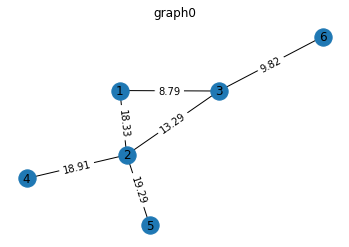

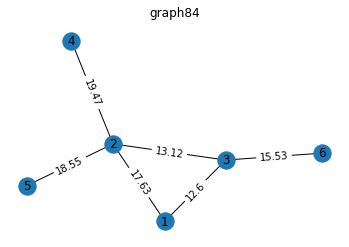

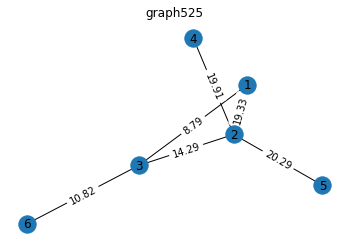

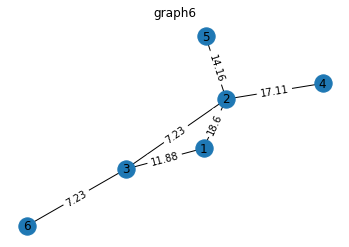

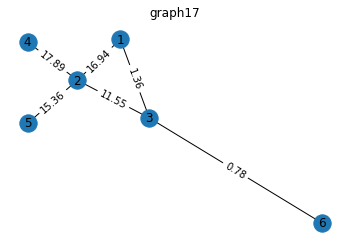

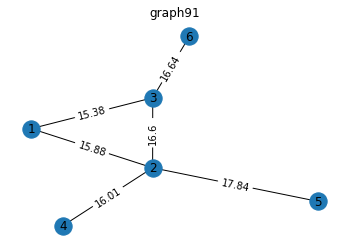

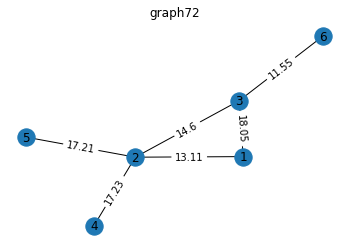

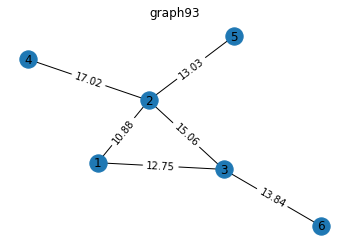

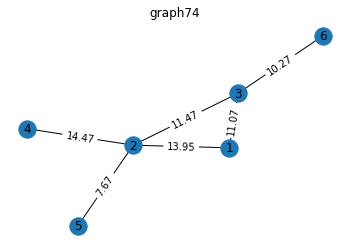

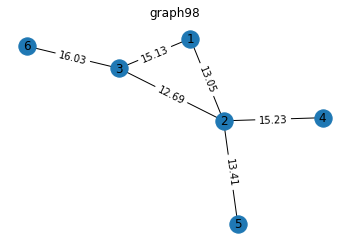

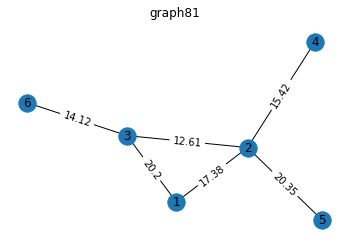

In [207]:
print("cos mode")
draw(top10_mode_cos, names_mode_cos, '', False)

cos except min max


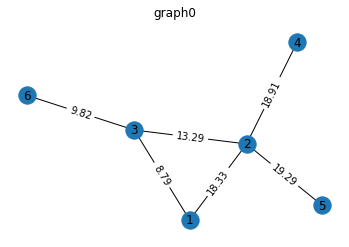

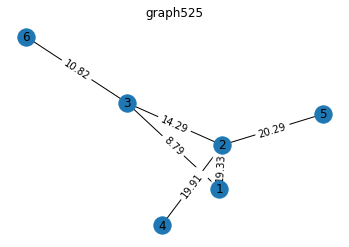

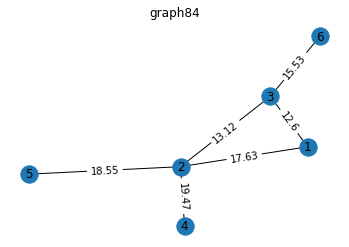

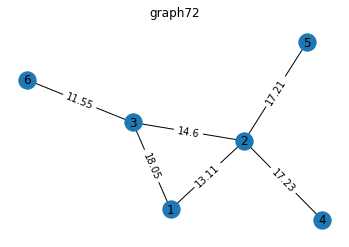

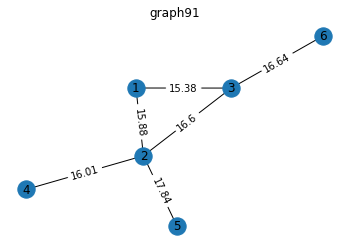

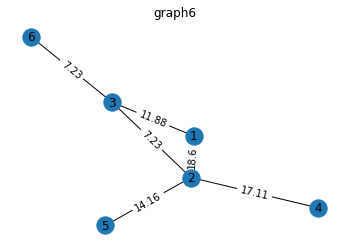

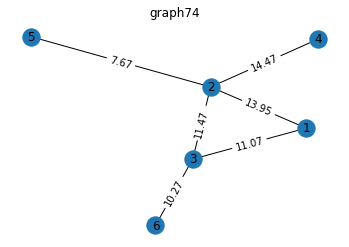

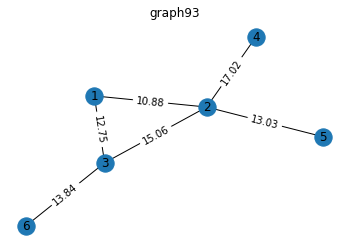

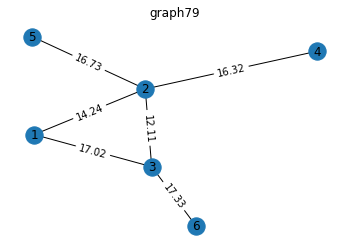

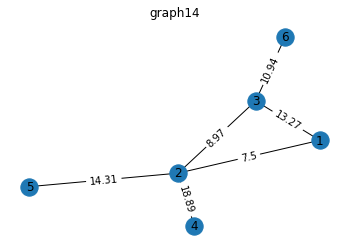

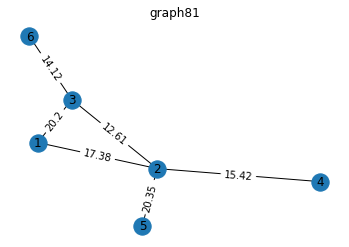

In [149]:
print("cos except min max")
draw(top10_except_cos, names_except_cos, '', False)

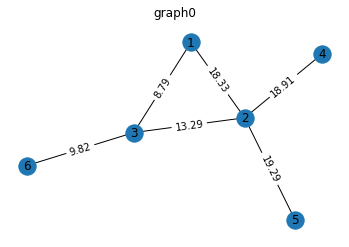

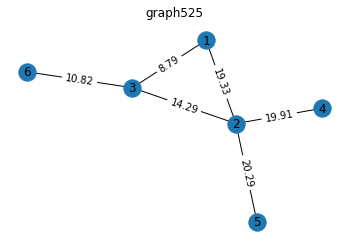

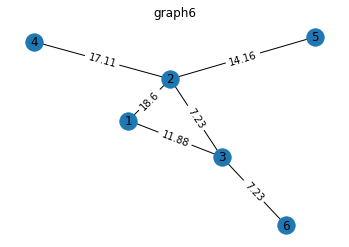

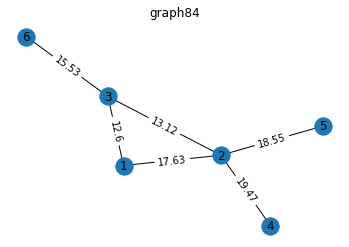

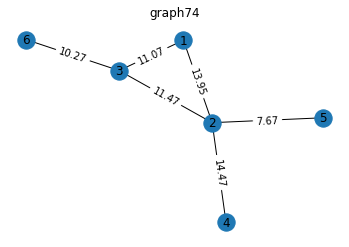

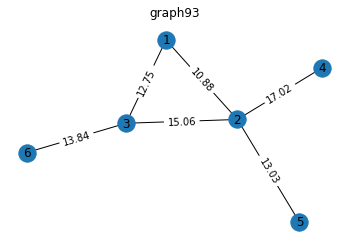

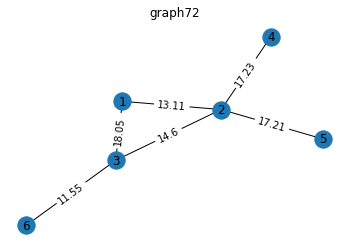

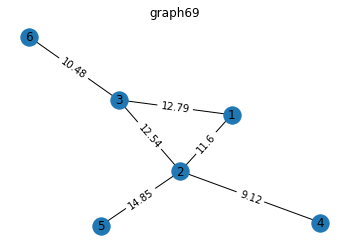

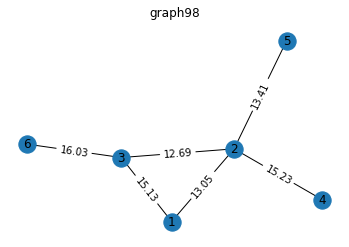

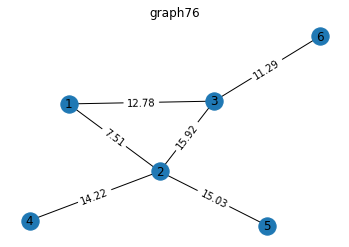

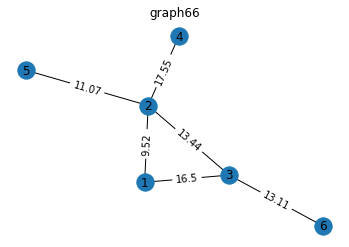

In [30]:
draw(top10_sum_cos, names_sum_cos, '', False)

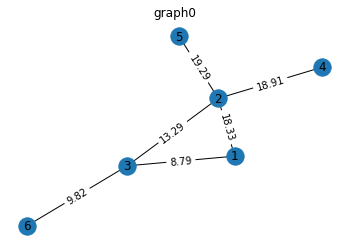

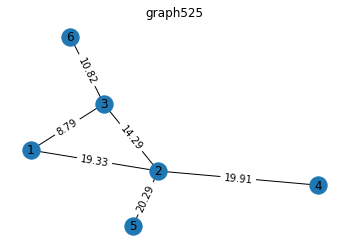

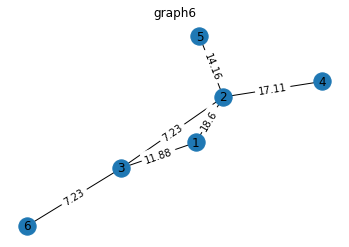

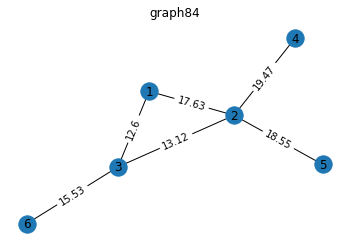

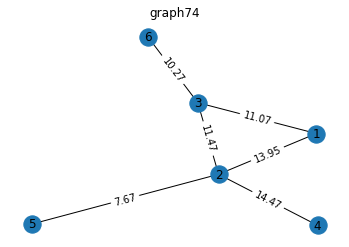

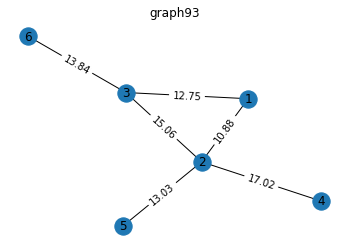

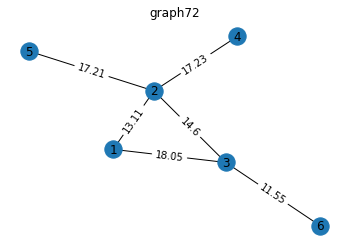

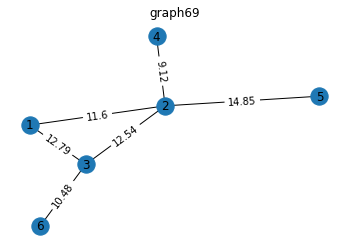

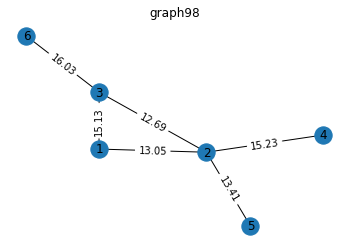

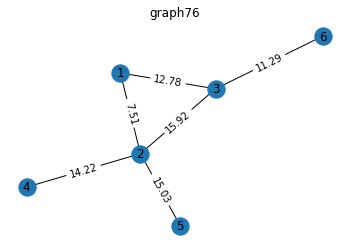

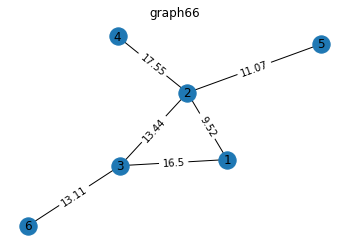

In [31]:
draw(top10_avg_cos, names_avg_cos, '', False)

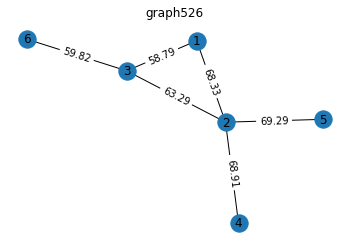

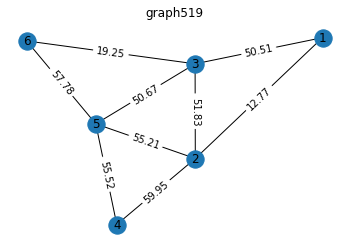

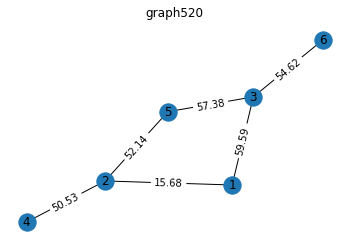

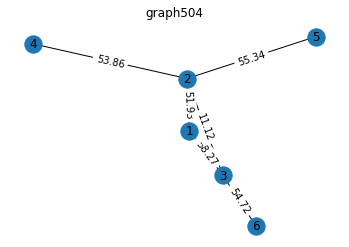

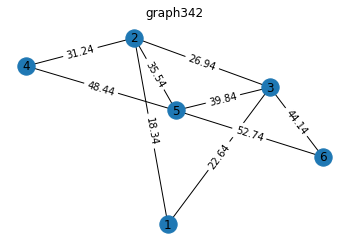

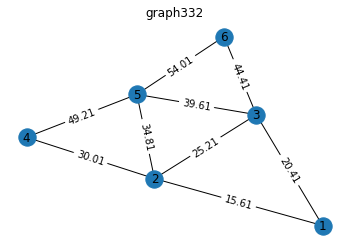

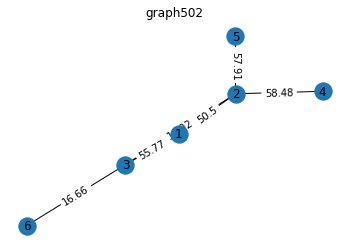

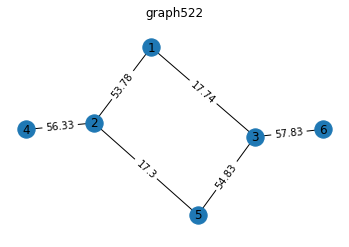

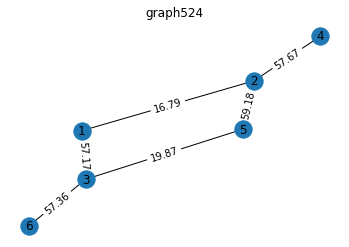

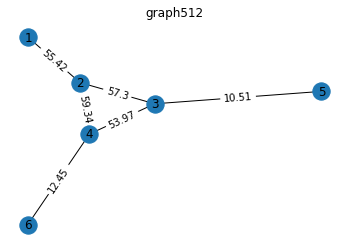

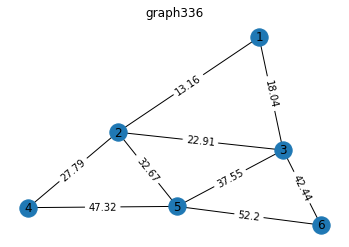

In [32]:
draw(back10_except_cos, names_except_cos[::-1], '', False)

In [127]:
mode_embedding[0]

array([-0.7615175 ,  0.        ,  0.        , -0.42478958,  0.8154586 ,
        0.        ,  0.        ,  0.        , -0.13336857,  0.        ,
        0.        ,  0.08319736,  0.75266176,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.45645085,
        0.        ,  0.        , -0.7615942 ,  0.        ,  0.        ,
        0.49640194, -0.9430218 , -0.07528461,  0.        ,  0.        ,
        0.9821518 ,  0.93581766, -0.45099282,  0.        ,  0.        ,
        0.41101357,  0.        , -0.48642313,  0.7615942 ,  0.7615942 ,
        0.72286636,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.44487116,  0.        ,  0.57553244,  0.        ,
        0.7615942 ,  0.        ,  0.        ,  0.73066515,  0.        ,
        0.2505372 , -0.87804157,  0.        , -0.43331838, -0.4742253 ,
        0.36776295,  0.        ,  0.        ,  0.        ], dtype=float32)

In [128]:
mode_embedding[525]

array([-0.76151156,  0.        ,  0.        , -0.4050398 ,  0.80646247,
        0.        ,  0.        ,  0.        , -0.13596456,  0.        ,
        0.        ,  0.05965236,  0.7311941 ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        , -0.42559063,
        0.        ,  0.        , -0.7615942 ,  0.        ,  0.        ,
        0.4763248 , -0.94433004, -0.06744974,  0.        ,  0.        ,
        0.97954416,  0.9411154 , -0.42498434,  0.        ,  0.        ,
        0.        ,  0.        , -0.4867015 ,  0.7615942 ,  0.7615942 ,
        0.70201707,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.42595187,  0.        ,  0.5586791 ,  0.        ,
        0.7615942 ,  0.        ,  0.        ,  0.71492344,  0.        ,
        0.27911597, -0.7615942 ,  0.        , -0.40818027, -0.4658854 ,
        0.35598007,  0.        ,  0.        ,  0.        ], dtype=float32)

In [129]:
mode_embedding[526]

array([-0.57714736, -0.20280045,  0.6223357 , -0.7555754 ,  0.        ,
        0.        ,  0.        ,  0.1752129 , -0.30652073,  0.        ,
        0.        ,  0.03268323,  0.        ,  0.        ,  0.        ,
        0.        ,  0.40045905,  0.        ,  0.        ,  0.95416147,
        0.        ,  0.        ,  0.        , -0.20732945,  0.37469873,
        0.        ,  0.98162603, -0.11106168, -0.7613104 ,  0.        ,
        0.        ,  0.999096  ,  0.        , -0.69980955,  0.        ,
        0.        ,  0.        ,  0.        ,  0.40964556,  0.7615942 ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.29180703,  0.        ,  0.        ,  0.        ,
        0.7615942 ,  0.        , -0.18954533,  0.        ,  0.        ,
        0.24144161,  0.70693773,  0.        ,  0.        ,  0.        ,
       -0.30643237,  0.        ,  0.4845028 ,  0.        ], dtype=float32)

In [130]:
cosine_distance(mode_embedding[0], mode_embedding[525])

0.008370816707611084

In [131]:
cosine_distance(mode_embedding[0], mode_embedding[526])

0.861250638961792